<a href="https://colab.research.google.com/github/2412tessa-gif/UM-MSP-BIGDATAINPHYSICS/blob/main/Copy_of_GW_tutorial_2_detector_noise_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [2]:
!pip install pycbc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 122.0 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolve

Note that we are importing some packages to be able to read the data.

In [3]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [4]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [5]:
duration = data.duration
sample_rate = data.sample_rate
num_samples = len(data)

delta_t = 1 / sample_rate
delta_f = 1 / duration

print(f"Duration of time series: {duration} s")
print(f"Sampling rate: {sample_rate} Hz")
print(f"Number of data points: {num_samples}")
print(f"Delta_t (time resolution): {delta_t} s")
print(f"Delta_f (frequency resolution): {delta_f} Hz")
print(f"\nRelation verification:")
print(f"num_samples = duration * sample_rate")
print(f"{num_samples} = {duration} * {sample_rate} = {duration * sample_rate}")

Duration of time series: 32.0 s
Sampling rate: 4096.0 Hz
Number of data points: 131072
Delta_t (time resolution): 0.000244140625 s
Delta_f (frequency resolution): 0.03125 Hz

Relation verification:
num_samples = duration * sample_rate
131072 = 32.0 * 4096.0 = 131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

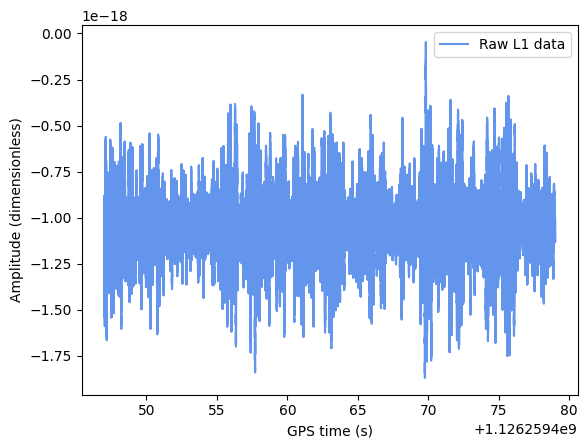

In [6]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-965006670.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Amplitude Spectral Density $\sqrt{S_n(f)}$ (1/$\sqrt{\mathrm{Hz}}$)')


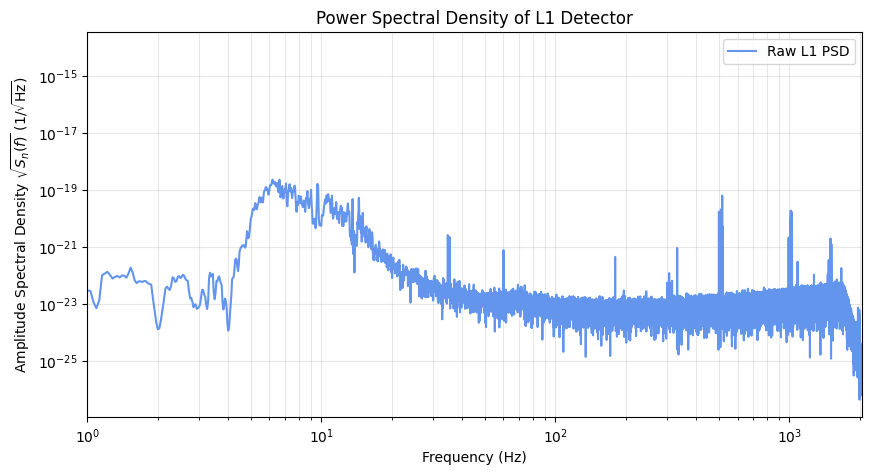

In [7]:
psd = data.filter_psd(data.duration, delta_f, 1)
nyquist_freq = sample_rate / 2

plt.figure(figsize=(10, 5))
plt.loglog(psd.sample_frequencies, np.sqrt(psd), label='Raw L1 PSD', color='cornflowerblue')
plt.xlim(1, nyquist_freq)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectral Density $\sqrt{S_n(f)}$ (1/$\sqrt{\mathrm{Hz}}$)')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.title('Power Spectral Density of L1 Detector')
plt.show()


The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


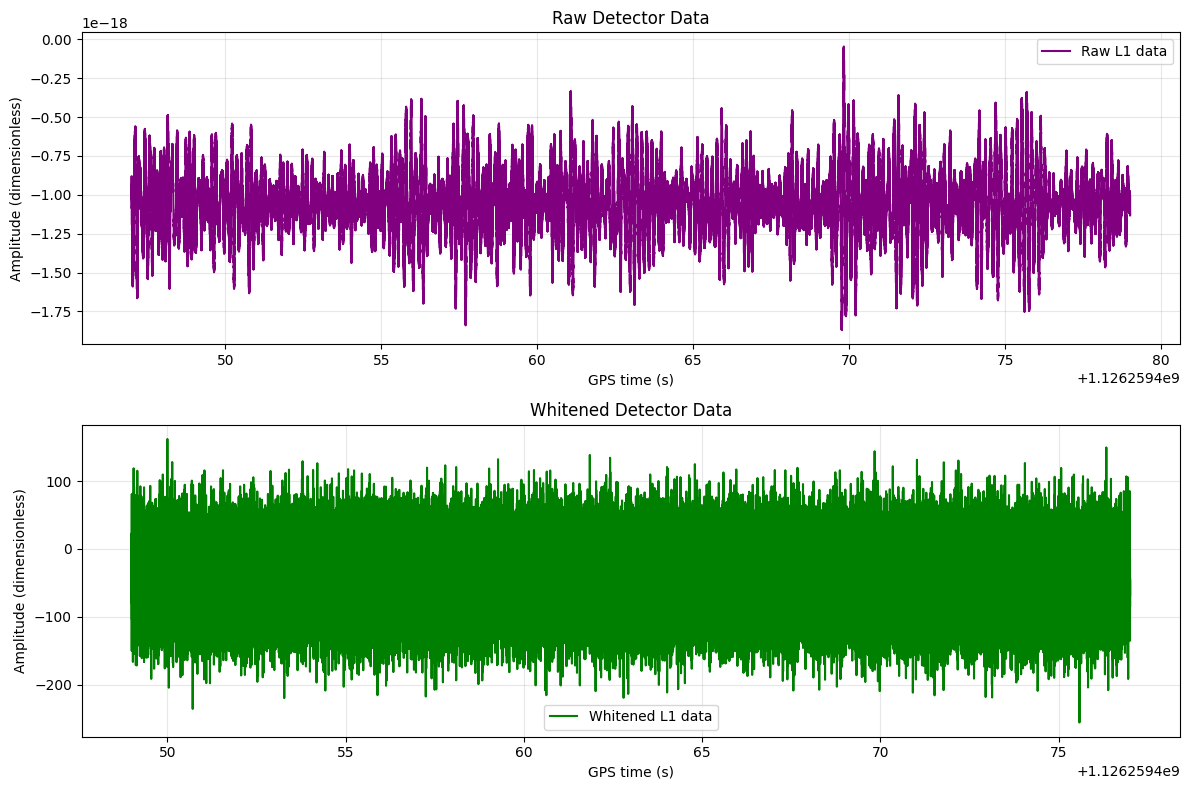

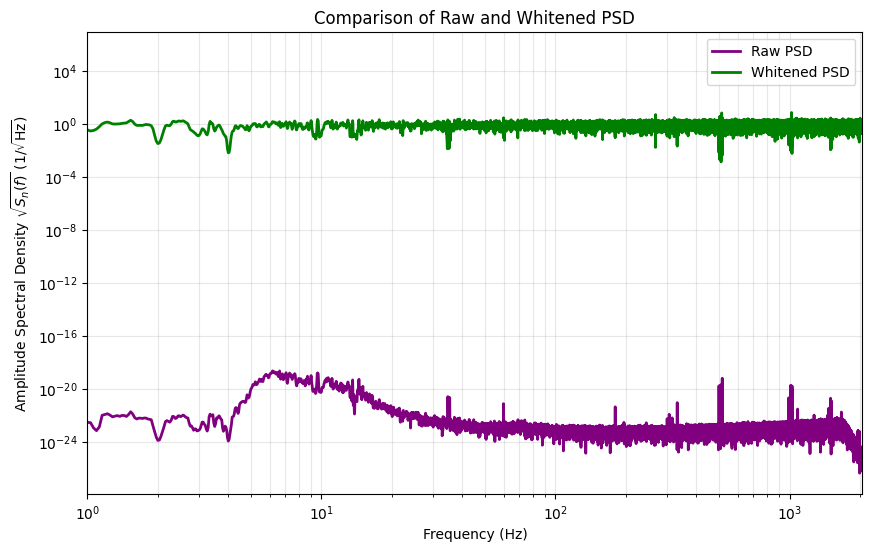

In [8]:
whitened_data = data.whiten(segment_duration=4, max_filter_duration=4)

# Estimate PSD of whitened data
psd_whitened = whitened_data.filter_psd(whitened_data.duration, delta_f, 1)

# Plot raw and whitened data side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot raw data
ax1.plot(data.sample_times, data, label='Raw L1 data', color='purple')
ax1.set_xlabel('GPS time (s)')
ax1.set_ylabel('Amplitude (dimensionless)')
ax1.set_title('Raw Detector Data')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot whitened data
ax2.plot(whitened_data.sample_times, whitened_data, label='Whitened L1 data', color='green')
ax2.set_xlabel('GPS time (s)')
ax2.set_ylabel('Amplitude (dimensionless)')
ax2.set_title('Whitened Detector Data')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot PSDs comparison
plt.figure(figsize=(10, 6))
plt.loglog(psd.sample_frequencies, np.sqrt(psd), label='Raw PSD', color='purple', linewidth=2)
plt.loglog(psd_whitened.sample_frequencies, np.sqrt(psd_whitened), label='Whitened PSD', color='green', linewidth=2)
plt.xlim(1, nyquist_freq)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amplitude Spectral Density $\sqrt{S_n(f)}$ (1/$\sqrt{\mathrm{Hz}}$)')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.title('Comparison of Raw and Whitened PSD')
plt.show()

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

In [13]:
if 250 < len(data) > 30:
    pass_data = data.lowpass_firpass_fir(250, 30)

low_pass = low_frequency_cutoff(250, 512, remove_corrupted={TRUE})
high_pass = high_frequency_cutoff(30, 512, remove_corrupted={TRUE})

AttributeError: 'TimeSeries' object has no attribute 'lowpass_firpass_fir'

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?